# Fine-tuning с for search deepfakes

## Библиотеки и env

In [ ]:
%env TRANSFORMERS_NO_TF=1
%env TRANSFORMERS_NO_FLAX=1
%env TOKENIZERS_PARALLELISM=false

%env TELEGRAM_BOT_TOKEN=7687177742:AAFFXhQfeHqNHU_S5bdaK31As5x5nMplleI
%env TELEGRAM_CHAT_ID=-1002402486670
%env TELEGRAM_THREAD_ID=5566

env: TRANSFORMERS_NO_TF=1
env: TRANSFORMERS_NO_FLAX=1
env: TOKENIZERS_PARALLELISM=false
env: TELEGRAM_BOT_TOKEN=7687177742:AAFFXhQfeHqNHU_S5bdaK31As5x5nMplleI
env: TELEGRAM_CHAT_ID=-1002402486670
env: TELEGRAM_THREAD_ID=5566


## Импорты + сиды

In [ ]:
import os
import re
import numpy as np
import PIL.Image as PILImage
from typing import List, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from datasets import load_from_disk
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

from transformers import (
    AutoImageProcessor,
    AutoModel,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    set_seed,
)

SEED = 42
set_seed(SEED)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/resources/.pyenv/versions/Python3.11.13/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Данные и processor

In [3]:
DATA_ROOT = "/workspace/Amarik/Diplom/datasets/Diffusion-real-dataset"
COMBINED_PATH = f"{DATA_ROOT}/Diffusion-Dataset"
MODEL_ID = "google/siglip2-base-patch16-512"

ds = load_from_disk(COMBINED_PATH)
processor = AutoImageProcessor.from_pretrained(MODEL_ID)
print(processor, '\n')
print(ds)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


SiglipImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "SiglipImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "SiglipProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}
 

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'source'],
        num_rows: 168000
    })
    validation: Dataset({
        features: ['image', 'label', 'source'],
        num_rows: 21000
    })
    test: Dataset({
        features: ['image', 'label', 'source'],
        num_rows: 21000
    })
})


In [4]:
from collections import Counter

for split in ["train", "test", "validation"]:
    if split in ds:
        labels = ds[split]["label"]
        counts = Counter(labels)
        print(f"{split} — распределение меток:")
        for label, count in sorted(counts.items()):
            print(f"  Класс {label}: {count} изображений")
        print()
    else:
        print(f"Сплит '{split}' отсутствует в датасете.\n")


train — распределение меток:
  Класс 0: 72000 изображений
  Класс 1: 96000 изображений

test — распределение меток:
  Класс 0: 9000 изображений
  Класс 1: 12000 изображений

validation — распределение меток:
  Класс 0: 9000 изображений
  Класс 1: 12000 изображений



## Аугментация

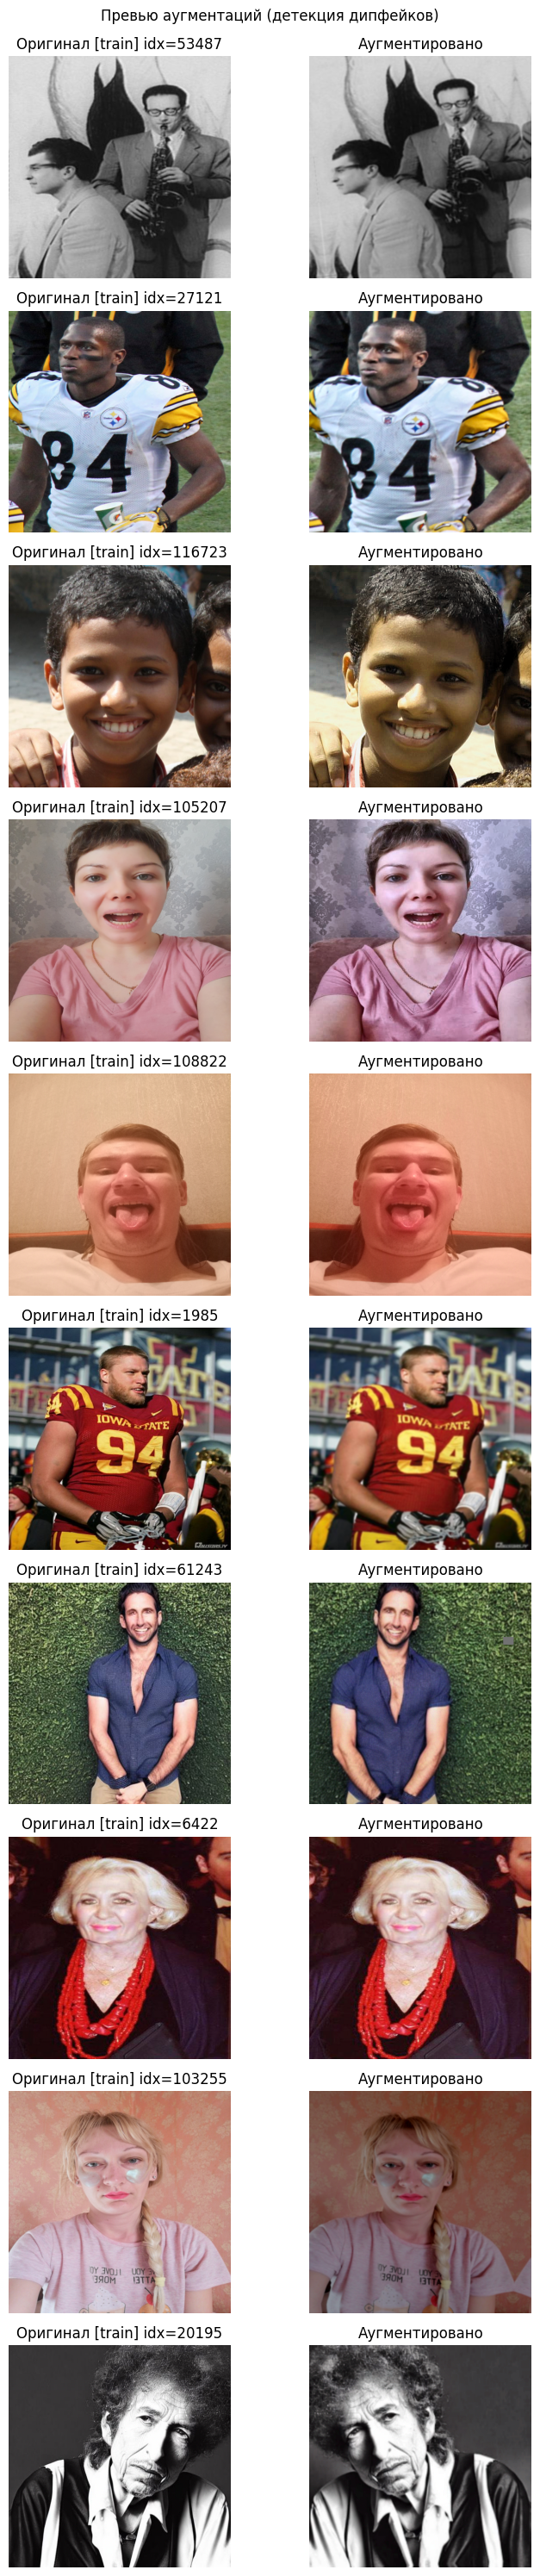

In [ ]:
import random
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from albumentations import (
    Compose, OneOf, HorizontalFlip, ShiftScaleRotate, RandomResizedCrop,
    ImageCompression, Downscale, MotionBlur, GaussianBlur,
    GaussNoise, MultiplicativeNoise, RandomBrightnessContrast, RandomGamma,
    HueSaturationValue, CLAHE, Sharpen, UnsharpMask, CoarseDropout, Resize
)

def build_deepfake_aug(
    img_size: Tuple[int, int],
    p_geom: float = 0.8,
    p_color: float = 0.9,
    p_artifacts: float = 0.9,
    p_noise_blur: float = 0.8,
    p_local: float = 0.2,
) -> Compose:
    h, w = img_size
    return Compose([
        OneOf([
            RandomResizedCrop(height=h, width=w, scale=(0.85, 1.0), ratio=(0.95, 1.05)),
            Resize(height=h, width=w),
        ], p=1.0),

        HorizontalFlip(p=0.5),

        ShiftScaleRotate(
            shift_limit=0.03, scale_limit=0.07, rotate_limit=8,
            border_mode=cv2.BORDER_REFLECT_101, p=p_geom
        ),

        OneOf([
            ImageCompression(quality_lower=35, quality_upper=85, p=1.0),
            Downscale(scale_min=0.5, scale_max=0.9, interpolation=cv2.INTER_LINEAR, p=1.0),
        ], p=p_artifacts),

        OneOf([
            MotionBlur(blur_limit=(3, 9), p=1.0),
            GaussianBlur(blur_limit=(3, 7), p=1.0),
            GaussNoise(var_limit=(5.0, 30.0), p=1.0),
            MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=1.0),
        ], p=p_noise_blur),

        OneOf([
            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            HueSaturationValue(hue_shift_limit=8, sat_shift_limit=15, val_shift_limit=10, p=1.0),
            RandomGamma(gamma_limit=(80, 120), p=1.0),
            CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
        ], p=p_color),

        OneOf([
            CoarseDropout(
                max_holes=2,
                min_holes=1,
                max_height=h // 16,
                max_width=w // 16,
                min_height=h // 48,
                min_width=w // 48,
                fill_value=(114, 114, 114),
            ),
            Sharpen(alpha=(0.1, 0.3), lightness=(0.8, 1.2)),
            UnsharpMask(blur_limit=(3, 7)),
        ], p=p_local),
    ])


def pil_to_np_rgb(img: Image.Image) -> np.ndarray:
    """PIL -> np.uint8 RGB, HxWxC."""
    if img.mode != "RGB":
        img = img.convert("RGB")
    return np.array(img)

def apply_aug_np(img_rgb: np.ndarray, aug: Compose) -> np.ndarray:
    """Применить Albumentations к np.uint8 RGB."""
    out = aug(image=img_rgb)
    aug_img = out["image"]
    return aug_img

def sample_indices(n: int, total: int, seed: int = 123) -> List[int]:
    n = min(n, total)
    rng = random.Random(seed)
    return rng.sample(range(total), k=n)

def preview_hf_augmentations(
    ds_dict,
    processor,
    split: str = "train",
    n_samples: int = 10,
    seed: int = 123
) -> None:
    """
    Показывает n_samples строк: слева оригинал (приведённый к размеру processor),
    справа — аугментированный вариант.
    """
    assert split in ds_dict, f"Нет сплита '{split}' в DatasetDict"
    ds = ds_dict[split]
    h = processor.size["height"]
    w = processor.size["width"]
    aug = build_deepfake_aug(img_size=(h, w))

    idxs = sample_indices(n_samples, len(ds), seed=seed)

    fig, axes = plt.subplots(len(idxs), 2, figsize=(8, 3 * len(idxs)))
    if len(idxs) == 1:
        axes = np.array([axes])

    for row, i in enumerate(idxs):
        example = ds[i]
        img = example["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        orig = img.resize((w, h), resample=Image.BILINEAR)
        orig_np = pil_to_np_rgb(orig)

        aug_np = apply_aug_np(orig_np, aug)

        axes[row, 0].imshow(orig_np)
        axes[row, 0].set_title(f"Оригинал [{split}] idx={i}")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(aug_np)
        axes[row, 1].set_title("Аугментировано")
        axes[row, 1].axis("off")

    fig.suptitle("Превью аугментаций (детекция дипфейков)", y=0.995)
    plt.tight_layout()
    plt.show()


preview_hf_augmentations(ds_dict=ds, processor=processor, split="train", n_samples=10, seed=None)


## Небольшая «прослойка» для Albumentations

In [ ]:
from dataclasses import dataclass
import numpy as np
from PIL import Image
import random

@dataclass
class AlbumentationsAugmenter:
    aug: Compose
    p: float = 0.4

    def __call__(self, img_pil: Image.Image, return_flag: bool = False):
        if img_pil.mode != "RGB":
            img_pil = img_pil.convert("RGB")
        do_aug = (random.random() < self.p)
        if not do_aug:
            return (img_pil, False) if return_flag else img_pil
        arr = np.array(img_pil)
        out = self.aug(image=arr)["image"]
        img_aug = Image.fromarray(out, mode="RGB")
        return (img_aug, True) if return_flag else img_aug


## Нормализация изображения

In [ ]:
import numpy as np
import PIL.Image as PILImage
import PIL.ImageFile as PILImageFile
from typing import Tuple, Optional

PILImageFile.LOAD_TRUNCATED_IMAGES = True
PILImage.MAX_IMAGE_PIXELS = None

try:
    import PIL.ImageCms as ImageCms
    _HAS_CMS = True
except Exception:
    _HAS_CMS = False

def _to_uint8(arr: np.ndarray) -> np.ndarray:
    """Привести к uint8 безопасно из uint16/float/инт/NaN-inf."""
    if arr.dtype == np.uint8:
        return arr
    arr = np.nan_to_num(arr, nan=0.0, posinf=255.0, neginf=0.0)
    if np.issubdtype(arr.dtype, np.floating):
        if arr.max() <= 1.0:
            arr = arr * 255.0
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    elif np.issubdtype(arr.dtype, np.integer):
        info = np.iinfo(arr.dtype)
        if info.max > 255:
            arr = (arr.astype(np.float32) / info.max) * 255.0
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        else:
            arr = arr.astype(np.uint8)
    else:
        arr = arr.astype(np.float32)
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    return arr

def _apply_exif_transpose(img: PILImage.Image) -> PILImage.Image:
    """Повернуть/отзеркалить по EXIF-ориентации (если есть)."""
    try:
        return PILImage.ImageOps.exif_transpose(img)
    except Exception:
        return img

def _to_srgb(img: PILImage.Image) -> PILImage.Image:
    """Перевести в sRGB с учётом ICC-профиля, если доступен ImageCms."""
    if not _HAS_CMS:
        return img.convert("RGB")
    try:
        icc = img.info.get("icc_profile", None)
        if icc:
            src = ImageCms.ImageCmsProfile(bytes(icc))
            dst = ImageCms.createProfile("sRGB")
            intent = ImageCms.INTENT_PERCEPTUAL
            img = ImageCms.profileToProfile(img, src, dst, renderingIntent=intent, outputMode="RGB")
            return img
    except Exception:
        pass
    return img.convert("RGB")

def _alpha_blend(img: PILImage.Image, bg: Tuple[int,int,int]=(0,0,0)) -> PILImage.Image:
    """Смешать RGBA с фоном (по умолчанию чёрный)."""
    if img.mode == "RGBA":
        bg_img = PILImage.new("RGB", img.size, bg)
        bg_img.paste(img, mask=img.split()[-1])
        return bg_img
    return img

def normalize_image_to_rgb(img_in, alpha_mode: str="blend_black") -> PILImage.Image:
    """
    Приводит любое входное изображение (PIL/np.ndarray) к формату:
    - sRGB, RGB, uint8, 3 канала
    - корректирует EXIF ориентацию
    - убирает/смешивает альфу
    Поддерживает режимы alpha: "blend_black" | "blend_white" | "drop"
    """
    if isinstance(img_in, PILImage.Image):
        img = img_in
    else:
        arr = img_in if isinstance(img_in, np.ndarray) else np.array(img_in)
        arr = _to_uint8(arr)
        if arr.ndim == 2:
            arr = np.stack([arr, arr, arr], axis=-1)
        elif arr.ndim == 3 and arr.shape[-1] == 1:
            arr = np.repeat(arr, 3, axis=-1)
        img = PILImage.fromarray(arr, mode="RGB" if arr.ndim == 3 and arr.shape[-1] == 3 else None)

    img = _apply_exif_transpose(img)

    mode = img.mode
    if mode in ("1", "L", "P"):
        img = _to_srgb(img.convert("RGB"))
    elif mode in ("LA", "RGBA"):
        if alpha_mode == "drop":
            img = img.convert("RGB")
        else:
            bg = (0,0,0) if alpha_mode == "blend_black" else (255,255,255)
            img = _alpha_blend(img.convert("RGBA"), bg=bg)
    elif mode in ("CMYK", "YCbCr"):
        img = _to_srgb(img)
    elif mode in ("I", "I;16", "F"):
        arr = _to_uint8(np.array(img))
        img = PILImage.fromarray(arr, mode="L").convert("RGB")
    else:
        if mode != "RGB":
            try:
                img = img.convert("RGB")
            except Exception:
                img = _to_srgb(img)

    return img


## Обёртка датасета 

In [ ]:
from multiprocessing import Value
import torch
from torch.utils.data import Dataset

class StandardizedDeepfakeDataset(Dataset):
    def __init__(self, hf_dataset, processor,
                 alpha_mode: str = "blend_black",
                 notify_telegram: bool = False,
                 max_tg_reports: int = 10,
                 augment=None,
                 aug_counter: Value = None,
                 total_counter: Value = None):
        self.ds = hf_dataset
        self.processor = processor
        self.alpha_mode = alpha_mode
        self.notify_telegram = notify_telegram
        self._tg_reports = 0
        self._tg_reports_max = max_tg_reports
        self.augment = augment
        self.aug_counter = aug_counter
        self.total_counter = total_counter

        self._zero_pixel = torch.zeros(
            3, processor.size["height"], processor.size["width"], dtype=torch.float32
        )

    def __len__(self): return len(self.ds)

    def __getitem__(self, i):
        ex = self.ds[i]
        was_aug = False
        try:
            img = normalize_image_to_rgb(ex["image"], alpha_mode=self.alpha_mode)

            if self.augment is not None:
                img, was_aug = self.augment(img, return_flag=True)

            pixel = self.processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        except Exception as e:
            pixel = self._zero_pixel.clone()
            was_aug = False
            msg = f"[STD-IMG] index={i} source={ex.get('source','?')} error={repr(e)}"
            print(msg)
            if self.notify_telegram and self._tg_reports < self._tg_reports_max:
                try: send_telegram_message(f"⚠️ Проблема с изображением\n<code>{msg}</code>")
                except Exception: pass
                self._tg_reports += 1

        if self.total_counter is not None:
            with self.total_counter.get_lock():
                self.total_counter.value += 1
        if was_aug and (self.aug_counter is not None):
            with self.aug_counter.get_lock():
                self.aug_counter.value += 1

        label = torch.tensor(int(ex["label"]), dtype=torch.long)
        return {"pixel_values": pixel, "labels": label}


In [ ]:
H, W = processor.size["height"], processor.size["width"]
train_aug = build_deepfake_aug(img_size=(H, W))
train_augmenter = AlbumentationsAugmenter(aug=train_aug, p=0.4)
train_augmenter = AlbumentationsAugmenter(aug=train_aug, p=0.5)

from multiprocessing import Value
aug_counter  = Value('i', 0)
total_counter= Value('i', 0)

train_ds = StandardizedDeepfakeDataset(
    ds["train"], processor,
    alpha_mode="blend_black",
    notify_telegram=True,
    augment=train_augmenter,
    aug_counter=aug_counter,
    total_counter=total_counter,
)
val_ds = StandardizedDeepfakeDataset(ds["validation"], processor, alpha_mode="blend_black")
test_ds= StandardizedDeepfakeDataset(ds["test"],       processor, alpha_mode="blend_black")


## Метрики и collate

In [10]:
def _flatten_logits(logits) -> np.ndarray:
    arr = np.asarray(logits)
    if arr.ndim == 2 and arr.shape[1] == 1:
        return arr[:, 0]
    return arr.ravel()

In [11]:
def collate_fn(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    pixel_values = torch.stack([b["pixel_values"] for b in batch], dim=0)
    labels = torch.stack([b["labels"] for b in batch], dim=0)
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics_from_logits(logits: np.ndarray, labels: np.ndarray):
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= 0.5).astype(np.int32)
    out = {"accuracy": float(accuracy_score(labels, preds))}
    try: out["auroc"] = float(roc_auc_score(labels, probs))
    except Exception: out["auroc"] = float("nan")
    try: out["ap"] = float(average_precision_score(labels, probs))
    except Exception: out["ap"] = float("nan")
    return out

def hf_compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = _flatten_logits(logits)
    return compute_metrics_from_logits(logits, labels)


## Телеграм-логер + колбэк с полными метриками на val/test

In [ ]:
import requests

def _get_env(name_main, *aliases):
    v = os.environ.get(name_main)
    if v: return v
    for a in aliases:
        v = os.environ.get(a)
        if v: return v
    return None

def send_telegram_message(text: str):
    token = _get_env("TELEGRAM_BOT_TOKEN", "TG_BOT_TOKEN")
    chat_id = _get_env("TELEGRAM_CHAT_ID", "TG_CHAT_ID")
    thread_id = _get_env("TELEGRAM_THREAD_ID", "TG_THREAD_ID")
    if not token or not chat_id:
        print("[tg] skip:", text[:120])
        return
    url = f"https://api.telegram.org/bot{token}/sendMessage"
    payload = {"chat_id": int(chat_id), "text": text, "parse_mode": "HTML"}
    if thread_id: payload["message_thread_id"] = int(thread_id)
    try:
        requests.post(url, json=payload, timeout=5)
    except Exception as e:
        print(f"[tg] error: {e}")
        
from transformers import TrainerCallback

class AugStatsCallback(TrainerCallback):
    def __init__(self, aug_counter: Value, total_counter: Value, tag: str = "train"):
        self.aug_counter = aug_counter
        self.total_counter = total_counter
        self.tag = tag

    def on_epoch_end(self, args, state, control, **kwargs):
        a = self.aug_counter.value
        t = self.total_counter.value
        ratio = (a / t) if t > 0 else 0.0
        send_telegram_message(
            f"🎨 <b>Aug stats (epoch {int(state.epoch)})</b>\n"
            f"{self.tag}: <code>{a}/{t}</code> ≈ <code>{ratio:.1%}</code>"
        )
        with self.aug_counter.get_lock():   self.aug_counter.value = 0
        with self.total_counter.get_lock(): self.total_counter.value = 0


import time
import torch

class TelegramMetricsCallback(TrainerCallback):
    def __init__(self, trainer_ref, eval_dataset, test_dataset, log_every_steps=100, ema_beta=0.98):
        self.trainer_ref = trainer_ref
        self.eval_ds = eval_dataset
        self.test_ds = test_dataset
        self.log_every = log_every_steps
        self._last_step = -1
        self._ema_beta = ema_beta
        self._ema_loss = None
        self._last_t = None
        self._last_seen = 0

    def on_train_begin(self, args, state, control, **kwargs):
        self._last_t = time.time()
        self._last_seen = 0
        send_telegram_message(
            f"🚀 <b>Старт all SigLIP2</b>\n"
            f"epochs=<code>{args.num_train_epochs}</code>, "
            f"bs=<code>{args.per_device_train_batch_size}</code>"
        )

    def on_log(self, args, state, control, logs=None, **kwargs):
        if not logs: return
        step = state.global_step
        if step == self._last_step: return
        if step % self.log_every != 0: return
        self._last_step = step

        loss = logs.get("loss")
        if loss is not None:
            if self._ema_loss is None: self._ema_loss = loss
            else: self._ema_loss = self._ema_beta * self._ema_loss + (1 - self._ema_beta) * loss

        now = time.time()
        seen = int(state.global_step) * args.per_device_train_batch_size * args.gradient_accumulation_steps * max(1, args.world_size if hasattr(args, "world_size") else 1)
        dt = now - (self._last_t or now)
        dsamp = seen - self._last_seen
        thr = (dsamp / dt) if dt > 0 else 0.0
        self._last_t = now
        self._last_seen = seen

        try:
            if torch.cuda.is_available():
                free, total = torch.cuda.mem_get_info()
                vram = f"{(total-free)/1024**3:.1f} / {total/1024**3:.1f} GB"
            else:
                vram = "CPU"
        except Exception:
            vram = "N/A"

        lr = logs.get("learning_rate")

        msg = (f"🔁 step <b>{step}</b>\n"
               f"Loss: <code>{loss:.4f}</code>  EMA: <code>{(self._ema_loss or loss):.4f}</code>\n"
               f"LR: <code>{(lr if lr is not None else 0):.2e}</code>\n"
               f"Throughput: <code>{thr:.1f} samp/s</code>\n"
               f"GPU: <code>{vram}</code>\n"
               f"Aug(p): <code>~40%</code>")
        send_telegram_message(msg)


    def _eval_full_split(self, dataset, split_name: str):
        preds = self.trainer_ref.predict(dataset, metric_key_prefix=f"{split_name}")
        logits = _flatten_logits(preds.predictions)
        labels = preds.label_ids.astype(np.int32)
        return compute_metrics_from_logits(logits, labels)

    def on_evaluate(self, args, state, control, **kwargs):
        try:
            v = self._eval_full_split(self.eval_ds, "val_full")
            send_telegram_message(
                f"📈 <b>Val(full)</b> @ {state.global_step}\n"
                f"ACC: <code>{v['accuracy']:.4f}</code>\n"
                f"AUROC: <code>{v['auroc']:.4f}</code>\n"
                f"AP: <code>{v['ap']:.4f}</code>"
            )
        except Exception as e:
            send_telegram_message(f"⚠️ val_full error: <code>{e}</code>")

        try:
            t = self._eval_full_split(self.test_ds, "test_full")
            send_telegram_message(
                f"🧪 <b>Test(full)</b> @ {state.global_step}\n"
                f"ACC: <code>{t['accuracy']:.4f}</code>\n"
                f"AUROC: <code>{t['auroc']:.4f}</code>\n"
                f"AP: <code>{t['ap']:.4f}</code>"
            )
        except Exception as e:
            send_telegram_message(f"⚠️ test_full error: <code>{e}</code>")

    def on_train_end(self, args, state, control, **kwargs):
        send_telegram_message("✅ <b>Обучение завершено</b>")


# Training

In [ ]:
H, W = processor.size["height"], processor.size["width"]
train_aug = build_deepfake_aug(img_size=(H, W))

train_augmenter = AlbumentationsAugmenter(
    aug=train_aug,
    p=0.6
)

from multiprocessing import Value
aug_counter  = Value('i', 0)
total_counter = Value('i', 0)

train_ds = StandardizedDeepfakeDataset(
    ds["train"],
    processor,
    alpha_mode="blend_black",
    notify_telegram=True,
    augment=train_augmenter,
    aug_counter=aug_counter,
    total_counter=total_counter,
)

val_ds = StandardizedDeepfakeDataset(
    ds["validation"],
    processor,
    alpha_mode="blend_black"
)

test_ds = StandardizedDeepfakeDataset(
    ds["test"],
    processor,
    alpha_mode="blend_black"
)


In [ ]:
class DeepfakeSigLIPFull(nn.Module):
    """
    Полный finetuning SigLIP2:
    - backbone разморожен
    - head обучаем
    """
    def __init__(self, model_id: str, processor):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_id)
        assert hasattr(self.backbone, "get_image_features")

        with torch.no_grad():
            dummy = torch.zeros(1, 3, processor.size["height"], processor.size["width"])
            feat_dim = self.backbone.get_image_features(pixel_values=dummy).shape[-1]

        self.head = nn.Sequential(
            nn.LayerNorm(feat_dim),
            nn.Linear(feat_dim, 1)
        )

        for p in self.backbone.parameters():
            p.requires_grad = True

    def forward(self, pixel_values, labels=None):
        feats = self.backbone.get_image_features(pixel_values=pixel_values)
        logits = self.head(feats).squeeze(-1)

        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels.float())

        return {"loss": loss, "logits": logits}


model = DeepfakeSigLIPFull(MODEL_ID, processor).to(device)

n_total = sum(p.numel() for p in model.parameters())
n_train = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {n_total/1e6:.2f}M, Trainable: {n_train/1e6:.2f}M")


Total params: 375.83M, Trainable: 375.83M


In [ ]:
training_args = TrainingArguments(
    output_dir="./siglip2_deepfake-diffusion-full",
    seed=SEED,
    remove_unused_columns=False,

    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,

    gradient_accumulation_steps=1,
    num_train_epochs=5,

    learning_rate=1e-5,
    weight_decay=0.05,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",

    fp16=False,
    bf16=torch.cuda.is_available(),

    logging_steps=100,
    report_to=[],
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,

    metric_for_best_model="eval_auroc",
    greater_is_better=True,

    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    dataloader_persistent_workers=False,

    max_grad_norm=1.0,
)


In [ ]:
def make_full_trainer():
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        processing_class=processor,
        data_collator=collate_fn,
        compute_metrics=hf_compute_metrics,
    )

    tg_callback = TelegramMetricsCallback(
        trainer_ref=trainer,
        eval_dataset=val_ds,
        test_dataset=test_ds,
        log_every_steps=100,
    )
    trainer.add_callback(tg_callback)

    trainer.add_callback(
        AugStatsCallback(
            aug_counter=aug_counter,
            total_counter=total_counter,
            tag="train"
        )
    )

    return trainer


trainer = make_full_trainer()

torch.set_float32_matmul_precision("high")

train_result = trainer.train()
trainer.save_model()
trainer.save_state()

final_val = trainer.evaluate()
final_test = trainer.predict(test_ds)
final_val, final_test.metrics


/resources/.pyenv/versions/Python3.11.13/lib/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
/resources/.pyenv/versions/Python3.11.13/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss


/resources/.pyenv/versions/Python3.11.13/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
